<a href="https://colab.research.google.com/github/Dipendra7/2015lab1/blob/master/pytorch001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install -r "/content/drive/MyDrive/Spiking neural network/requirementfiles/requirements.txt"

  Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
ERROR: Could not find a version that satisfies the requirement Box2D==2.3.10 (from versions: 2.0.2b1, 2.3b0, 2.3.2)
ERROR: No matching distribution found for Box2D==2.3.10


In [46]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import gym

print(gym.__version__)

0.25.2


In [47]:
all_envs = gym.envs.registry.all()
env_ids = [env.id for env in all_envs]

print(f'There are {len(env_ids)} gym environments. Such as {env_ids[:12]}')

There are 996 gym environments. Such as ['ALE/Tetris-v5', 'ALE/Tetris-ram-v5', 'ALE/MiniatureGolf-v5', 'ALE/MiniatureGolf-ram-v5', 'ALE/Breakout-v5', 'ALE/Breakout-ram-v5', 'ALE/Kangaroo-v5', 'ALE/Kangaroo-ram-v5', 'ALE/VideoPinball-v5', 'ALE/VideoPinball-ram-v5', 'ALE/Turmoil-v5', 'ALE/Turmoil-ram-v5']


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [48]:
 !pip install "gym[atari, accept-rom-license]"

In [49]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0

In [50]:
#env = gym.make('SpaceInvadersNoFrameskip-v4')
env = gym.make('Pong-v0')
env.seed(1234)

n_episodes = 20

for episode in range(n_episodes):

    episode_reward = 0
    done = False
    state = env.reset()

    while not done:

        action = env.action_space.sample()

        state, reward, done, _ = env.step(action)

        episode_reward += reward

    print(f'episode: {episode+1}, reward: {episode_reward}')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


episode: 1, reward: -20.0
episode: 2, reward: -19.0
episode: 3, reward: -21.0
episode: 4, reward: -21.0
episode: 5, reward: -20.0
episode: 6, reward: -20.0
episode: 7, reward: -20.0
episode: 8, reward: -21.0
episode: 9, reward: -20.0
episode: 10, reward: -19.0
episode: 11, reward: -20.0
episode: 12, reward: -21.0
episode: 13, reward: -20.0
episode: 14, reward: -21.0
episode: 15, reward: -18.0
episode: 16, reward: -21.0
episode: 17, reward: -19.0
episode: 18, reward: -19.0
episode: 19, reward: -20.0
episode: 20, reward: -21.0


In [51]:
action = env.action_space.sample() #select random action, uniformly between high and low for continuous

print('selected action:', action)

selected action: 5


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

In [53]:
SEED = 1234

train_env = gym.make('Pong-v0')
test_env = gym.make('Pong-v0')
train_env.metadata['render_fps'] = 30

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

train_env.seed(1234)

state = train_env.reset()

print('state type:', type(state))
print('state shape:', state.shape)

state type: <class 'numpy.ndarray'>
state shape: (210, 160, 3)


In [55]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [56]:
class DQN(nn.Module):  ##DQN

    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super(DQN, self).__init__()
        self.fc0 = nn.Conv2d(3, 1, 5)
        self.fc2 = nn.Linear(32136, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.dropout = nn.Dropout(dropout)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.fc0(x))
        x = torch.flatten(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [57]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 1024
OUTPUT_DIM = train_env.action_space.n

#policy = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

policy = DQN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

In [58]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [59]:
policy.apply(init_weights)

DQN(
  (fc0): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (fc2): Linear(in_features=32136, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [60]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [61]:
def train(env, policy, optimizer, discount_factor, frames):

    policy.train()

    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to('cuda')

        action_pred = policy(state)

        action_prob = F.softmax(action_pred, dim = -1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())
        frames.append(state)
        env.render('rgb_array')

        log_prob_actions.append(log_prob_action.reshape(1))
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions, dim=0)

    returns = calculate_returns(rewards, discount_factor)

    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward

In [62]:
def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

In [68]:
def update_policy(returns, log_prob_actions, optimizer):

    # Ensure both tensors are on the same device
    device = log_prob_actions.device  # Get the device of log_prob_actions
    returns = returns.to(device)  # Move returns to the same device

    returns = returns.detach()

    loss = - (returns * log_prob_actions).sum()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    return loss.item()

In [73]:
def evaluate(env, policy):

    policy.eval()

    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        state = state.to(next(policy.parameters()).device)

        with torch.no_grad():

            action_pred = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward

In [74]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.color import rgb2gray
from skimage.transform import resize

In [75]:
def save_video(frames, filename):
   height, width, _ = frames[0].shape
   fig = plt.figure()
   plt.axis('off')
   ims = [[plt.imshow(frame, animated=True)] for frame in frames]


   ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
   ani.save(filename, writer='pillow')
   print(f"Video saved as {filename}")

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Video saved as episode_2.gif
| Episode:   1 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_3.gif
| Episode:   2 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_4.gif
| Episode:   3 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_5.gif
| Episode:   4 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_6.gif
| Episode:   5 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_7.gif
| Episode:   6 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_8.gif
| Episode:   7 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_9.gif
| Episode:   8 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_10.gif
| Episode:   9 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_11.gif
| Episode:  10 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_12.gif
| Episode:  11 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_13.gif
| Episode:  12 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_14.gif
| Episode:  13 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_15.gif
| Episode:  14 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_16.gif
| Episode:  15 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_17.gif
| Episode:  16 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_18.gif
| Episode:  17 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_19.gif
| Episode:  18 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_20.gif
| Episode:  19 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_21.gif
| Episode:  20 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-75-7c9926487f0e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Video saved as episode_22.gif
| Episode:  21 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_23.gif
| Episode:  22 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_24.gif
| Episode:  23 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_25.gif
| Episode:  24 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_26.gif
| Episode:  25 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_27.gif
| Episode:  26 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Video saved as episode_28.gif
| Episode:  27 | Mean Train Rewards: -21.0 | Mean Test Rewards: -21.0 |


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


KeyboardInterrupt: 

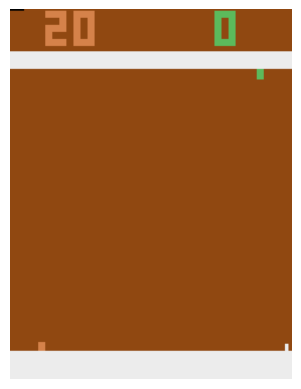

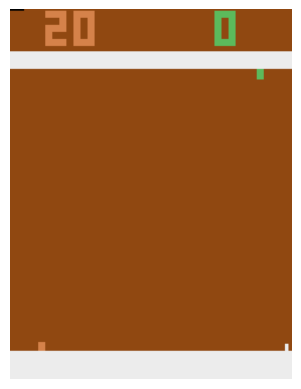

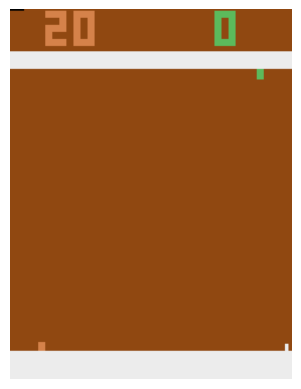

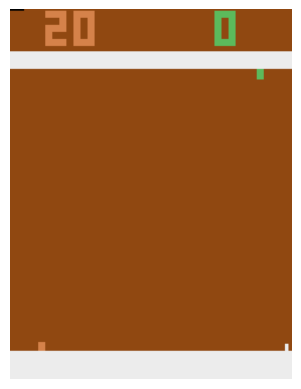

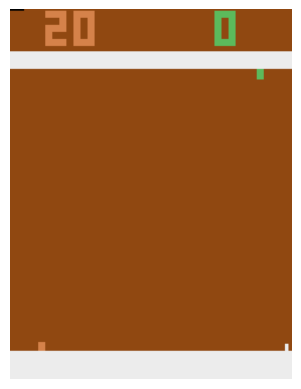

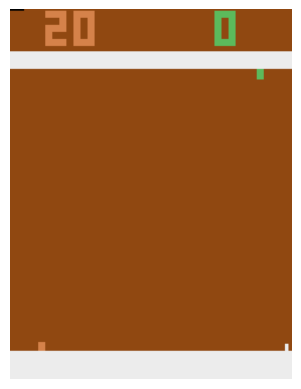

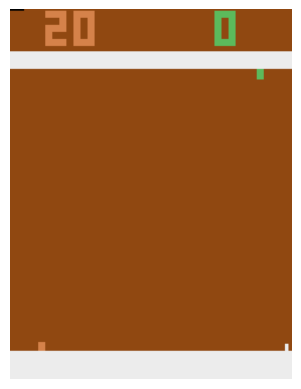

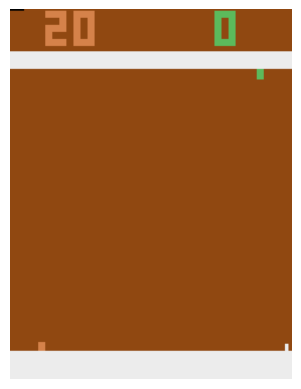

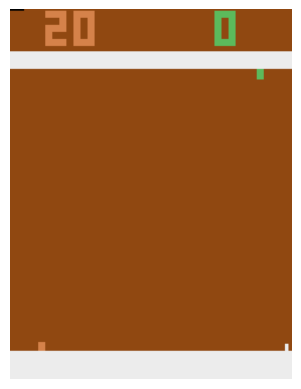

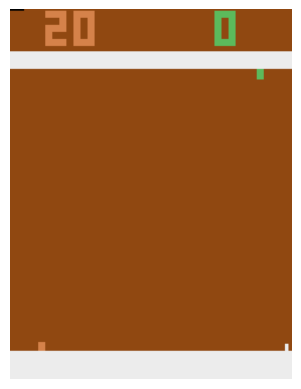

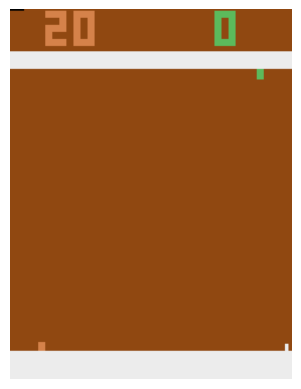

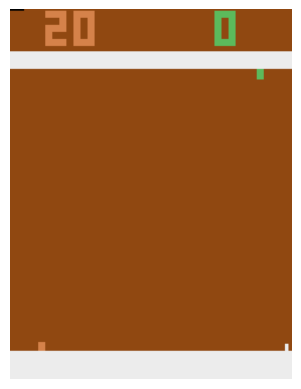

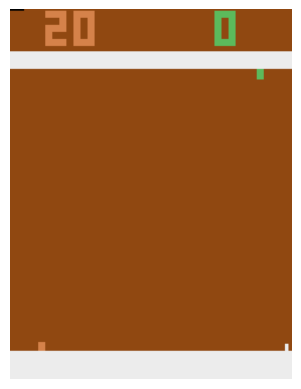

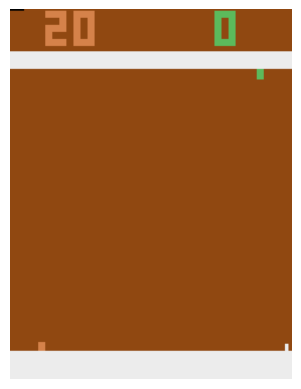

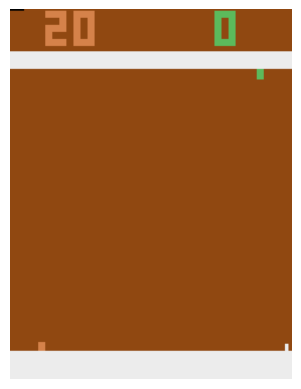

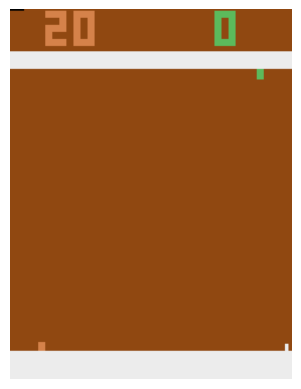

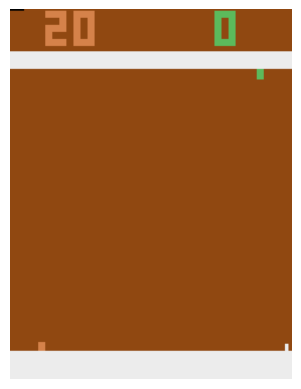

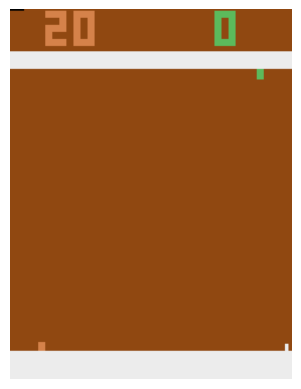

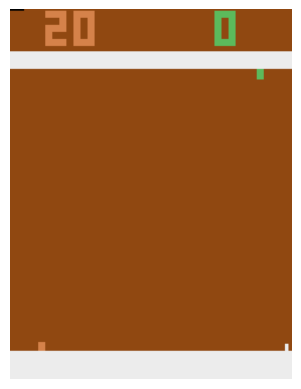

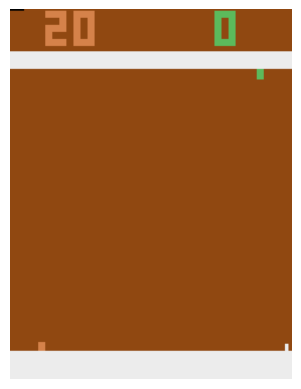

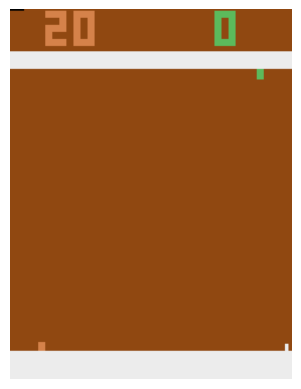

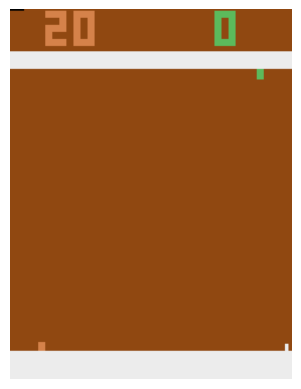

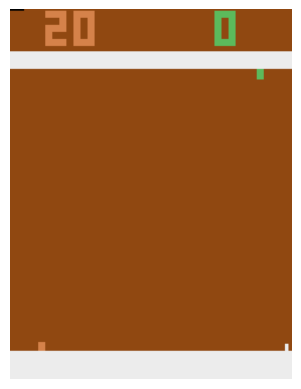

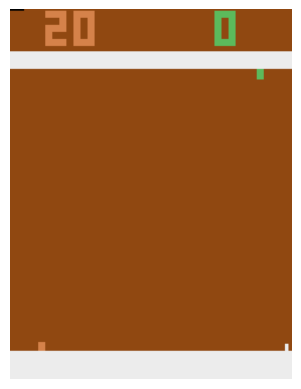

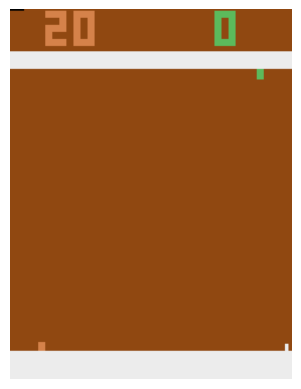

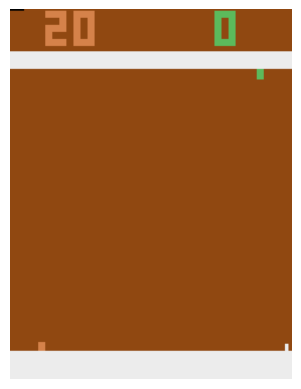

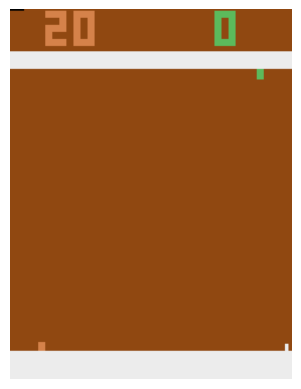

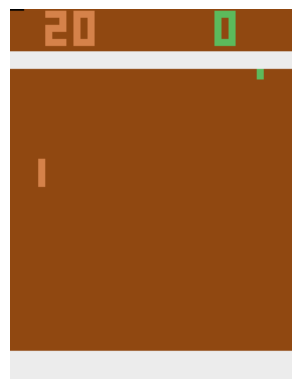

In [76]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 1

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    frames = []
    loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, frames)
    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    save_video(frames, f'episode_{episode + 1}.gif')


    if episode % PRINT_EVERY == 0:

        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')

    if mean_test_rewards >= REWARD_THRESHOLD:

        print(f'Reached reward threshold in {episode} episodes')

        break